In [255]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_svmlight_file

bank_data = pd.read_csv('bank-additional-full.csv', sep=';')
# bank_data_n = pd.read_csv('datasets/bank-additional/bank-additional.csv', sep=';')
bank_data['labels'] = bank_data['y'].apply(lambda x: 0 if x == 'no' else 1)

In [256]:
bank_data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

### Preprocessing

In [35]:
from sklearn.preprocessing import OneHotEncoder
#  Change no to unknown
#  Categorical Data
catg_col = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
bank_data_catg = bank_data[catg_col]
bank_data_catg['housing'] = bank_data_catg['housing'].apply(lambda x: 'no' if x == 'unknown' else x)
bank_data_catg['loan'] = bank_data_catg['loan'].apply(lambda x: 'no' if x == 'unknown' else x)
bank_data_catg['default'] = bank_data_catg['default'].apply(lambda x: 'no' if x == 'unknown' else x)

job_encoder = OneHotEncoder()
bank_catg_onehot = job_encoder.fit_transform(bank_data_catg)

C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

### Standard Scaler

In [38]:
from sklearn.preprocessing import StandardScaler

numerical_col = list(set(bank_data.drop(['y','labels'],axis=1).columns) - set(catg_col))
scaling = StandardScaler()
bank_numer = bank_data[numerical_col]
bank_numer_scaled = scaling.fit_transform(bank_numer)

In [221]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def get_all_metrics_score(predict_value, real_value):
    acc_scr = accuracy_score(predict_value, real_value)
    pre_scr = precision_score(predict_value, real_value)
    recall_scr = recall_score(predict_value, real_value)
    roc_scr = roc_auc_score(predict_value, real_value)
    f1_scr = f1_score(predict_value, real_value)
    print("SCORE")
    print("Accuracy:", acc_scr)
    print("Precision:", pre_scr)
    print("Recall:", recall_scr)
    print("F1 Score:", f1_scr)
    print("ROC AUC:", roc_scr)

def plot_learning_curve(model, X, y, title='Learning Curve, for Training Sets and Validation Sets'):
    
    train_sizes, train_scores, valid_scores = learning_curve(model, X, y, 
                                                             train_sizes=np.linspace(0.1, 1.0, 10),cv=5, scoring='accuracy')
    mean_train_scores = np.mean(train_scores,axis=1)
    mean_valid_scores = np.mean(valid_scores,axis=1)
    fig, ax = plt.subplots()
    ax.plot(train_sizes, mean_train_scores, "b-", label='Training Sets')
    ax.plot(train_sizes, mean_valid_scores, "r-", label='Validation Sets')
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Mean Accuracy')
    ax.set_title(title)
    ax.legend()
    plt.show(fig)

### Combine

In [40]:
features = np.concatenate((bank_numer_scaled,bank_catg_onehot.toarray()),axis=1)
labels = bank_data['labels']

Start Preping some normal ML models

In [171]:
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV

random_state=42
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=random_state)
X_train_real, X_validation, y_train_real, y_validation = train_test_split(X_train, y_train, test_size=0.3, random_state=random_state)

### Decision Tree

In [222]:
# Train test split
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

param_grid = [
   {'ccp_alpha': [0, 0.0005,0.001, 0.0015 ,0.002, 0.01, 0.02],
    'criterion':['gini', 'entropy']
   }
]
# Try GRID SEARCH
tree_clf = DecisionTreeClassifier(random_state=random_state)
tree_grid_clf = GridSearchCV(tree_clf, param_grid, cv=5,
                            scoring='accuracy', return_train_score=True)
tree_grid_clf.fit(X_train, y_train)
best_tree = tree_grid_clf.best_estimator_
#  Record fit time
start_time = time.time()
best_tree.fit(X_train, y_train)
stop_time = time.time()
print(f"Fit time: {stop_time - start_time} seconds")
pred_tree = best_tree.predict(X_test)
print("Train Score:", best_tree.score(X_train, y_train))
print("Performance:")
get_all_metrics_score(pred_tree, y_test)

Fit time: 0.37699460983276367 seconds
Train Score: 0.917593766986773
Performance:
SCORE
Accuracy: 0.9159126020745972
Precision: 0.5985686402081978
Recall: 0.636237897648686
F1 Score: 0.6168286959436808
ROC AUC: 0.7927217314044039


In [223]:
best_tree

DecisionTreeClassifier(ccp_alpha=0.0005, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

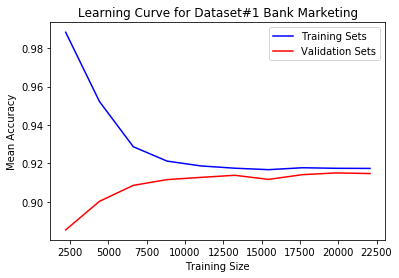

In [220]:
plot_learning_curve(best_tree, X_train, y_train, 'Learning Curve for Dataset#1 Bank Marketing')

In [112]:
# Unprune tree
unpruned_tree = DecisionTreeClassifier(ccp_alpha=0, random_state=random_state)
unpruned_tree.fit(X_train, y_train)
pred_unpruned_tree = unpruned_tree.predict(X_test)
get_all_metrics_score(pred_unpruned_tree, y_test)
print('Train Accuracy', unpruned_tree.score(X_train, y_train))

SCORE
Accuracy: 0.8866328257191202
Precision: 0.5094339622641509
Recall: 0.49872611464968153
F1 Score: 0.5040231734792405
ROC AUC: 0.7180064907441205
Train Accuracy 1.0


In [113]:
# Optimal Prune tree
pred_best_tree = best_tree.predict(X_test)
get_all_metrics_score(pred_best_tree, y_test)
print('Train Accuracy', best_tree.score(X_train, y_train))

SCORE
Accuracy: 0.9129699109835945
Precision: 0.538711776187378
Recall: 0.6359447004608295
F1 Score: 0.5833039802747446
ROC AUC: 0.7891301079393075
Train Accuracy 0.9151295524551549


In [215]:
# Extreme Prune Tree
pruned_tree = DecisionTreeClassifier(ccp_alpha=0.01, random_state=random_state)
pruned_tree.fit(X_train, y_train)
pred_extreme_pruned_tree = pruned_tree.predict(X_test)
get_all_metrics_score(pred_extreme_pruned_tree, y_test)
print('Train Accuracy', pruned_tree.score(X_train, y_train))

SCORE
Accuracy: 0.90274405944236
Precision: 0.4072869225764476
Recall: 0.6036644165863067
F1 Score: 0.4864024864024864
ROC AUC: 0.7655547313896809
Train Accuracy 0.9038956332668961


### Pruning Graph

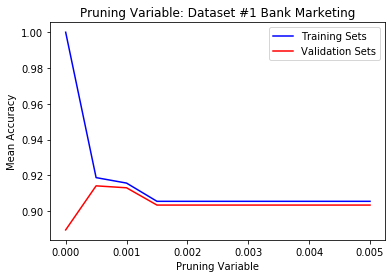

In [216]:
dtree_clfs = []
for i in np.linspace(0,  0.005, 11 ):
    dtree = DecisionTreeClassifier(ccp_alpha=i, random_state=random_state)
    dtree.fit(X_train_real, y_train_real)
    dtree_clfs.append(dtree)

train_score = [i.score(X_train_real, y_train_real) for i in dtree_clfs]
test_score = [i.score(X_validation, y_validation) for i in dtree_clfs]

fig, ax = plt.subplots()
ax.plot(np.linspace(0,  0.005, 11 ), train_score, "b-", label='Training Sets')
ax.plot(np.linspace(0,  0.005, 11 ), test_score, "r-", label='Validation Sets')
ax.set_xlabel('Pruning Variable')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Pruning Variable: Dataset #1 Bank Marketing')
ax.legend()
plt.show(fig)

###  KNN

In [224]:
knn_clf = KNeighborsClassifier()
param_grid = [
   {'n_neighbors':[ 9, 10, 11, 12, 13, 14, 15],
    'p':[1 , 2]}
]
knn_gird_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy', return_train_score=True)
knn_gird_search.fit(X_train, y_train)
knn_best_model = knn_gird_search.best_estimator_

start_time = time.time()
knn_best_model.fit(X_train, y_train)
stop_time = time.time()
print(f"Fit time: {stop_time - start_time} seconds")
pred_knn = knn_best_model.predict(X_test)
print("Train Score:", knn_best_model.score(X_train, y_train))
print("Performance:")
get_all_metrics_score(pred_knn, y_test)

Fit time: 0.6891229152679443 seconds
Train Score: 0.9187896358035876
Performance:
SCORE
Accuracy: 0.9056867505333628
Precision: 0.39947950553025374
Recall: 0.6310380267214799
F1 Score: 0.48924302788844615
ROC AUC: 0.7789500751673961


In [225]:
knn_best_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

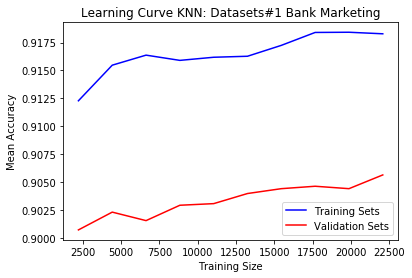

In [226]:
plot_learning_curve(knn_best_model, X_train, y_train, 'Learning Curve KNN: Datasets#1 Bank Marketing')

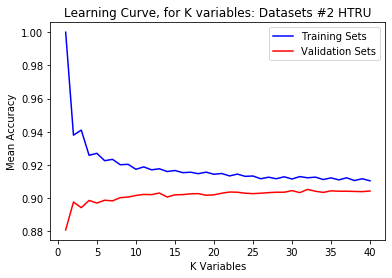

In [227]:
# K Learning Graph
knn_clfs = []
for i in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_real, y_train_real)
    knn_clfs.append(knn)
    
train_score = [i.score(X_train_real, y_train_real) for i in knn_clfs]
test_score = [i.score(X_validation, y_validation) for i in knn_clfs]

fig, ax = plt.subplots()
ax.plot(range(1, 41) , train_score, "b-", label='Training Sets')
ax.plot(range(1, 41) , test_score, "r-", label='Validation Sets')
ax.set_xlabel('K Variables')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Learning Curve, for K variables: Datasets #1 Bank Marketing')
ax.legend()
plt.show(fig)

In [266]:
# Get example score for K = 1, 11 (Optimal) and 40, 60
knn_clfs_n = []
for i in [1, 11, 40, 60]:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    knn_clfs_n.append(knn)
    
train_score_n = [i.score(X_train, y_train) for i in knn_clfs_n]
test_score_n = [i.score(X_test, y_test) for i in knn_clfs_n]
print("Train Score", train_score_n)
print("Test Score", test_score_n)

Train Score [1.0, 0.9187896358035876, 0.9100199311469469, 0.9081717702482334]
Test Score [0.8839108364599426, 0.9056867505333628, 0.9050982123151622, 0.9054660487015376]


### Boosting

In [229]:
param_grid =  [{'base_estimator__ccp_alpha':[0, 0.0005,0.001, 0.0015 ,0.002, 0.01, 0.02]}]

dtree = DecisionTreeClassifier()

ada_clf =  AdaBoostClassifier(DecisionTreeClassifier(),
                          n_estimators=300, random_state=random_state)

ada_grid_clf = GridSearchCV(ada_clf, param_grid, cv=5,
                            scoring='accuracy', return_train_score=True)
ada_grid_clf.fit(X_train, y_train)
ada_grid_best = ada_grid_clf.best_estimator_

start_time = time.time()
ada_grid_best.fit(X_train, y_train)
stop_time = time.time()
print(f"Fit time: {stop_time - start_time} seconds")
pred_ada = ada_grid_best.predict(X_test)
print("Train Score:", ada_grid_best.score(X_train, y_train))
print("Performance:")
get_all_metrics_score(pred_ada, y_test)

Fit time: 167.62713170051575 seconds
Train Score: 0.9185722051096213
Performance:
SCORE
Accuracy: 0.9127492091517693
Precision: 0.5283018867924528
Recall: 0.6378633150039277
F1 Score: 0.5779359430604982
ROC AUC: 0.7895079562032625


In [230]:
ada_grid_best

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.001,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                     

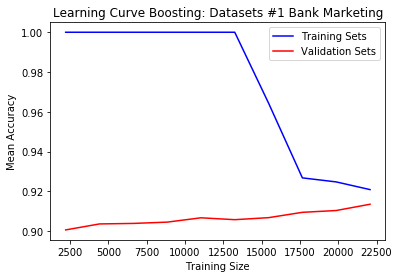

In [231]:
plot_learning_curve(ada_grid_best, X_train, y_train, 'Learning Curve Boosting: Datasets #1 Bank Marketing')

In [247]:
# NO prune
dtree = DecisionTreeClassifier(ccp_alpha=0)

ada_clf =  AdaBoostClassifier(dtree,
                          n_estimators=300, random_state=random_state)

ada_clf.fit(X_train_real, y_train_real)
# ada_grid_best = ada_grid_clf.best_estimator_
pred_ada_noprune = ada_clf.predict(X_validation)
print(get_all_metrics_score(pred_ada_noprune, y_validation))
print(ada_clf.score(X_train_real, y_train_real))

SCORE
Accuracy: 0.8873052301002536
Precision: 0.5277185501066098
Recall: 0.5025380710659898
F1 Score: 0.514820592823713
ROC AUC: 0.7209016102519421
None
1.0


In [248]:
# Extreme prune
dtree = DecisionTreeClassifier(ccp_alpha=0.01)

ada_clf =  AdaBoostClassifier(dtree,
                          n_estimators=300, random_state=random_state)

ada_clf.fit(X_train_real, y_train_real)
# ada_grid_best = ada_grid_clf.best_estimator_
pred_ada_noprune = ada_clf.predict(X_validation)
get_all_metrics_score(pred_ada_noprune, y_validation)
print(ada_clf.score(X_train, y_train))
print('Train Score', ada_clf.score(X_train_real, y_train_real))

SCORE
Accuracy: 0.9073559608648387
Precision: 0.40831556503198296
Recall: 0.6436974789915967
F1 Score: 0.4996738421395957
ROC AUC: 0.785734736372425
0.90954883131002
Train Score 0.9104887140194657


In [249]:
# Extra Extreme prune
dtree = DecisionTreeClassifier(ccp_alpha=0.02)

ada_clf =  AdaBoostClassifier(dtree,
                          n_estimators=300, random_state=random_state)

ada_clf.fit(X_train_real, y_train_real)
# ada_grid_best = ada_grid_clf.best_estimator_
pred_ada_noprune = ada_clf.predict(X_validation)
print(get_all_metrics_score(pred_ada_noprune, y_validation))
print('Train Score', ada_clf.score(X_train_real, y_train_real))

SCORE
Accuracy: 0.9034907597535934
Precision: 0.44136460554371004
Recall: 0.6008708272859217
F1 Score: 0.5089121081745545
ROC AUC: 0.7659163095586393
None
Train Score 0.9063988403396148


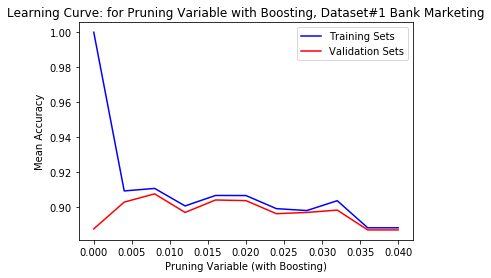

In [234]:
# Pruning Graph for Boosting!!
boosting_clfs = []
prune_size = np.linspace(0,  0.04, 11 )
for i in prune_size:
    dtree = DecisionTreeClassifier(ccp_alpha=i)
    ada_clf = AdaBoostClassifier(dtree,
                          n_estimators=300, random_state=random_state)
    ada_clf.fit(X_train_real, y_train_real)
    boosting_clfs.append(ada_clf)

train_score_ada = [i.score(X_train_real, y_train_real) for i in boosting_clfs]
test_score_ada = [i.score(X_validation, y_validation) for i in boosting_clfs]

fig, ax = plt.subplots()
ax.plot(prune_size, train_score_ada, "b-", label='Training Sets')
ax.plot(prune_size, test_score_ada, "r-", label='Validation Sets')
ax.set_xlabel('Pruning Variable (with Boosting)')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Learning Curve: for Pruning Variable with Boosting, Dataset#1 Bank Marketing')
ax.legend()
plt.show(fig)

### SVM

In [236]:
param_grid = [{
    'kernel': ['rbf', 'linear','poly','sigmoid'],
    'C': [0.001,0.01, 0.1, 1, 10, 100]
}]

svm_clf = SVC()
# svm_clf = SVC(C=1)
svm_grid_clf = GridSearchCV(svm_clf, param_grid, cv=5,
                            scoring='accuracy', return_train_score=True)

svm_grid_clf.fit(X_train, y_train)
svm_grid_best = svm_grid_clf.best_estimator_

start_time = time.time()
svm_grid_best.fit(X_train, y_train)
stop_time = time.time()
print(f"Fit time: {stop_time - start_time} seconds")
pred_svm = svm_grid_best.predict(X_test)
print("Train Score:", svm_grid_best.score(X_train, y_train))
print("Performance:")
get_all_metrics_score(pred_svm, y_test)

Fit time: 23.08003330230713 seconds
Train Score: 0.9221960500090596
Performance:
SCORE
Accuracy: 0.9114249981608181
Precision: 0.40793754066363047
Recall: 0.6807817589576547
F1 Score: 0.5101708706265257
ROC AUC: 0.8044849451353929


In [237]:
svm_grid_best

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

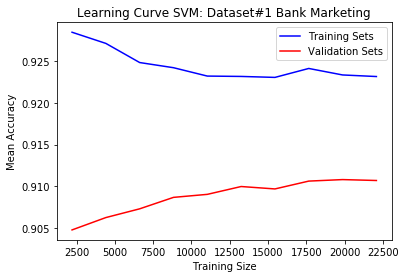

In [238]:
plot_learning_curve(svm_grid_best, X_train, y_train, "Learning Curve SVM: Dataset#1 Bank Marketing")

In [239]:
svm_clfs = []
kernel_list = ['rbf', 'linear','poly','sigmoid']
# using C from best params
for i in kernel_list:
    svm_clf = SVC(C=svm_grid_best.C, kernel=i)
    svm_clf.fit(X_train_real, y_train_real)
    svm_clfs.append(svm_clf)
    print("===================")
    print(f"Kernel {i}")
    print(f"Train Score {svm_clf.score(X_train_real, y_train_real)}")
    print(f"Validation Score {svm_clf.score(X_validation, y_validation)}")
    

Kernel rbf
Train Score 0.9247256160695796
Validation Score 0.9069935982606595
Kernel linear
Train Score 0.9046904120936011
Validation Score 0.8980553206909047
Kernel poly
Train Score 0.9335266100641955
Validation Score 0.9056649353786689
Kernel sigmoid
Train Score 0.8687098778214951
Validation Score 0.8699118250996497


In [252]:
# how about we varying C? => what will happen?
c_values = [ 0.001, 0.01, 0.1, 1, 10, 100]
svm_clfs = []
for i in c_values:
    svm = SVC(C=i,kernel=svm_grid_best.kernel)
    svm.fit(X_train_real, y_train_real)
    svm_clfs.append(svm)

train_score = [i.score(X_train_real, y_train_real) for i in svm_clfs]
test_score = [i.score(X_validation, y_validation) for i in svm_clfs]

In [253]:
pd.DataFrame(zip(c_values, train_score, test_score), columns=['C', 'Train Score', 'Validation Score'])

,C,Train Score,Validation Score
0,0.001,0.887917,0.886701
1,0.010,0.887969,0.886701
2,0.100,0.906554,0.901317
3,1.000,0.924726,0.906994
4,10.000,0.959774,0.904578
5,100.000,0.989025,0.895519


### Neural Networks

In [240]:
from sklearn.neural_network import MLPClassifier

param_grid = [{
    'activation': ['relu', 'logistic', 'tanh'],
    'hidden_layer_sizes':[(10,), (10,2), (10,4), (10, 8), (10, 16), (10, 32)]
}]


ann_clf = MLPClassifier(solver='adam', max_iter=300, random_state=random_state)
ann_grid_clf = GridSearchCV(ann_clf, param_grid, cv=5,
                           scoring='accuracy', return_train_score=True)

ann_grid_clf.fit(X_train, y_train)
ann_grid_clf_best = ann_grid_clf.best_estimator_

start_time = time.time()
ann_grid_clf_best.fit(X_train, y_train)
stop_time = time.time()
print(f"Fit time: {stop_time - start_time} seconds")
pred_ann = ann_grid_clf_best.predict(X_test)
print("Train Score:", ann_grid_clf_best.score(X_train, y_train))
print("Performance:")
get_all_metrics_score(pred_ann, y_test)

C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum ite

Fit time: 17.061766624450684 seconds
Train Score: 0.9207465120492843
Performance:
SCORE
Accuracy: 0.9148826601927462
Precision: 0.5172413793103449
Recall: 0.6570247933884298
F1 Score: 0.5788132508190754
ROC AUC: 0.79855196707296


In [241]:
ann_grid_clf_best

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 16), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum ite

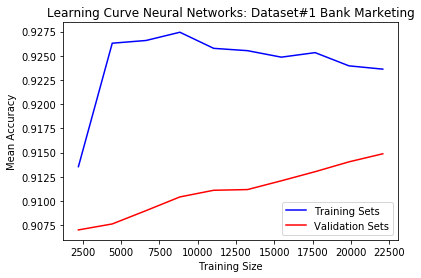

In [242]:
plot_learning_curve(ann_grid_clf_best, X_train, y_train, "Learning Curve Neural Networks: Dataset#1 Bank Marketing")

In [244]:
ann_clfs = []
activation_list = ['relu', 'logistic', 'tanh']
# using C from best params
for i in activation_list:
    ann_clf = MLPClassifier(activation=i,hidden_layer_sizes=ann_grid_clf_best.hidden_layer_sizes, solver='adam', max_iter=300, random_state=random_state)
    ann_clf.fit(X_train_real, y_train_real)
    ann_clfs.append(ann_clf)
    print("===================")
    print(f"Activation Function: {i}")
    print(f"Train Score {ann_clf.score(X_train_real, y_train_real)}")
    print(f"Validation Score {ann_clf.score(X_validation, y_validation)}")


Activation Function: relu
Train Score 0.9313004762890867
Validation Score 0.9088054112815558
Activation Function: logistic
Train Score 0.923534893352661
Validation Score 0.9114627370455369
Activation Function: tanh
Train Score 0.928453095879064
Validation Score 0.9079598985384708


C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


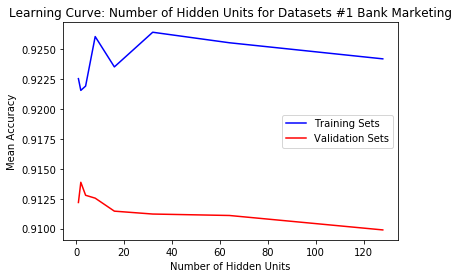

In [245]:
# For number of hidden units in the second layers
acc_train = []
acc_test = []
# clfs = []
hidden_units = [2**n for n in range(0, 8, 1)]
# hidden_units =
for i in hidden_units:
    if i == 0:
        sizes = (10,)
    else:
        sizes = (10,i)
    clf = MLPClassifier(activation='logistic', hidden_layer_sizes=sizes,max_iter=300, solver='adam', random_state=random_state)
    clf.fit(X_train_real, y_train_real)
    y_pred = clf.predict(X_validation)
    test_score = accuracy_score(y_validation, y_pred)
    acc_train.append(clf.score(X_train_real, y_train_real))
    acc_test.append(test_score)
    
fig, ax = plt.subplots()
ax.plot(list(hidden_units), acc_train, "b-", label='Training Sets')
ax.plot(list(hidden_units), acc_test, "r-", label='Validation Sets')
ax.set_xlabel('Number of Hidden Units')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Learning Curve: Number of Hidden Units for Datasets #1 Bank Marketing')
ax.legend()
plt.show(fig)

C:\Users\Por\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


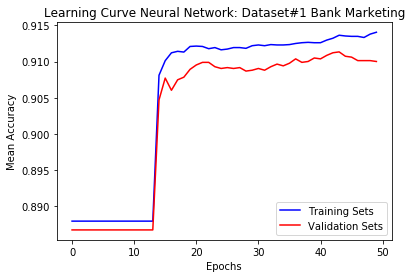

In [246]:
clf = MLPClassifier(activation=ann_grid_clf_best.activation, hidden_layer_sizes=ann_grid_clf_best.hidden_layer_sizes, learning_rate_init=0.001, random_state=1, max_iter=1, solver='adam', warm_start=True)
acc_train = []
acc_test = []
# clfs = []
times_range = range(50)
for i in times_range:
    clf.fit(X_train_real, y_train_real)
    y_pred = clf.predict(X_validation)
    test_score = accuracy_score(y_validation, y_pred)
    acc_train.append(clf.score(X_train_real, y_train_real))
    acc_test.append(test_score)
    
fig, ax = plt.subplots()
ax.plot( list(times_range), acc_train, "b-", label='Training Sets')
ax.plot(list(times_range), acc_test, "r-", label='Validation Sets')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Learning Curve Neural Network: Dataset#1 Bank Marketing')
ax.legend()
plt.show(fig)